## Question 3: Energy-based Models

- make a simple energy-based model with E(x,\theta) = f_{\theta}(x). Here, f_{\theta}() is a simple 2-layer convolutional network (CNN). You should design this CNN yourself, which include (at least) 2 convolutional layers.
- train and use Gibbs sampling and Langevin Dynamics method on USPS.

In [ ]:
import os
import json
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision.datasets import USPS
from torchvision import transforms
import pytorch_lightning as pl

sns.reset_orig()
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = USPS(root="../data", train=True, transform=transform, download=True)
test_set = USPS(root="../data", train=False, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4, pin_memory=True)

Seed set to 42


Device: cuda:0


## The model structure. I use 4 convolutional layers for a better outcome effect.

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module): # The main part of the energy model. x finally is the energy.
    def __init__(self, hidden_features=642, out_dim=1, **kwargs):
        super().__init__()
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),
            Swish(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),
            Swish(),
            nn.Flatten(),
            nn.Linear(c_hid3*4, c_hid3),
            Swish(),
            nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

class Sampler: # the Sampler, Langevin and Gibbs.
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=256, step_size=5): # Experience Replay Buffer to Speed Up Training.
        n_new = np.random.binomial(self.sample_size, 0.2)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

@staticmethod
def generate_samples(model, inp_imgs, steps=256, step_size=5, return_img_per_step=False, method="Langevin", num_candidates=10):
    is_training = model.training
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    
    if method == "Langevin": # Langevin Dynamics
        inp_imgs.requires_grad = True
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        imgs_per_step = []

        for _ in range(steps):
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)

            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        torch.set_grad_enabled(had_gradients_enabled)

    else:  # Gibbs sampling
        imgs_per_step = []
        batch_size, channels, height, width = inp_imgs.shape
        candidates = torch.linspace(-1.0, 1.0, num_candidates, device=inp_imgs.device)
        def energy_to_prob(energy):
            energy = energy - energy.min(dim=-1, keepdim=True)[0]  
            probs = torch.exp(-energy)
            return probs / probs.sum(dim=-1, keepdim=True)
        
        for _ in range(steps):
            for h in range(height):
                for w in range(width):
                    candidates_expanded = candidates.repeat(batch_size, channels, 1)
                    
                    energies = []
                    for c in range(candidates.size(0)):
                        temp_imgs = inp_imgs.clone()
                        temp_imgs[:, :, h, w] = candidates_expanded[:, :, c]
                        with torch.no_grad():
                            energy = model(temp_imgs)
                            energies.append(energy)
                    
                    energies = torch.stack(energies, dim=-1)
                    probs = energy_to_prob(energies)
                    selected = torch.multinomial(probs, 1).squeeze(-1)
                    new_values = candidates_expanded[torch.arange(batch_size), :, selected]
                    inp_imgs[:, :, h, w] = new_values
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone())

    for p in model.parameters():
        p.requires_grad = True
    model.train(is_training)

    if return_img_per_step:
        return torch.stack(imgs_per_step, dim=0)
    else:
        return inp_imgs

class DeepEnergyModel(pl.LightningModule): # The combined model.
    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()
        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)

        if self.current_epoch % 5 == 0 and batch_idx == 0:
            self.visualize_generations()
        return loss

    def validation_step(self, batch, batch_idx):
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)

    def on_train_epoch_end(self):
        pass

    def visualize_generations(self, batch_size=64, num_steps=256, vis_steps=8): # Generate Pictures in the Training Process
        os.makedirs('results', exist_ok=True)
        self.eval()
        start_imgs = torch.rand((batch_size,) + self.hparams["img_shape"]).to(self.device)
        start_imgs = start_imgs * 2 - 1

        with torch.no_grad():
            imgs_per_step = Sampler.generate_samples(self.cnn, start_imgs, steps=num_steps, step_size=10, return_img_per_step=True)

        final_imgs = imgs_per_step[-1]
        plt.figure(figsize=(12, 12))
        for i in range(batch_size):
            plt.subplot(8, 8, i+1)
            plt.imshow(final_imgs[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')

        plt.suptitle(f'Generated Images at Epoch {self.current_epoch}')
        plt.tight_layout()

        plt.savefig(f'results/generation_epoch_{self.current_epoch}.png', bbox_inches='tight', dpi=300)
        plt.close()
        self.train()

def train_model(**kwargs):
    trainer = pl.Trainer(
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=150,
        gradient_clip_val=0.1
    )

    model = DeepEnergyModel(**kwargs)
    trainer.fit(model, train_loader, test_loader)
    return model

## Train the model.

In [ ]:
model = train_model(img_shape=(1,16,16), batch_size=train_loader.batch_size, lr=1e-4, beta1=0.0)
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
new_model = DeepEnergyModel(img_shape=(1,16,16), batch_size=train_loader.batch_size, lr=1e-4, beta1=0.0)
new_model.load_state_dict(torch.load('model_weights.pth'))

## The outcomes.

In [4]:
def generate_and_display_samples(model, batch_size=64, num_steps=60, method="Langevin", num_candidates=20):
    import matplotlib.pyplot as plt
    model.eval()
    device = next(model.parameters()).device
    start_imgs = torch.rand((batch_size,) + model.hparams["img_shape"]).to(device)
    start_imgs = start_imgs * 2 - 1
    with torch.no_grad():
        final_imgs = Sampler.generate_samples(model.cnn,
            start_imgs, steps=num_steps,
            step_size=10, return_img_per_step=False, method=method,
            num_candidates=num_candidates)
    plt.figure(figsize=(8, 8))
    for i in range(batch_size):
        img = final_imgs[i].detach().cpu().squeeze()
        plt.subplot(8, 8, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle('Generated Images')
    plt.tight_layout()
    plt.show()
    model.train()

### The generated samples using Langevin dynamics.

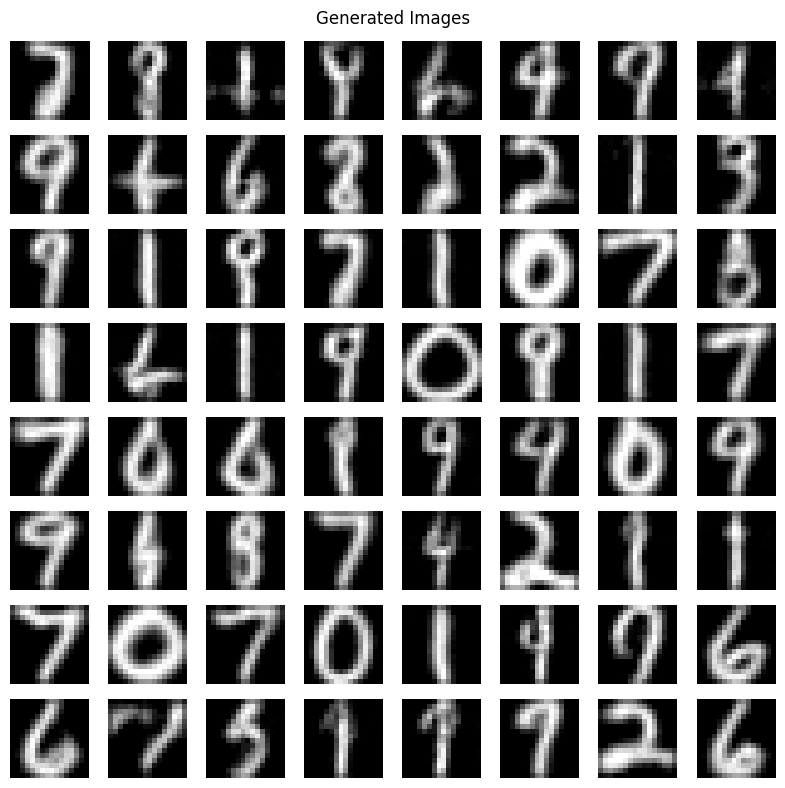

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)
generate_and_display_samples(new_model, num_steps=512, method="Langevin")

### The generated samples using Gibbs Sampling.

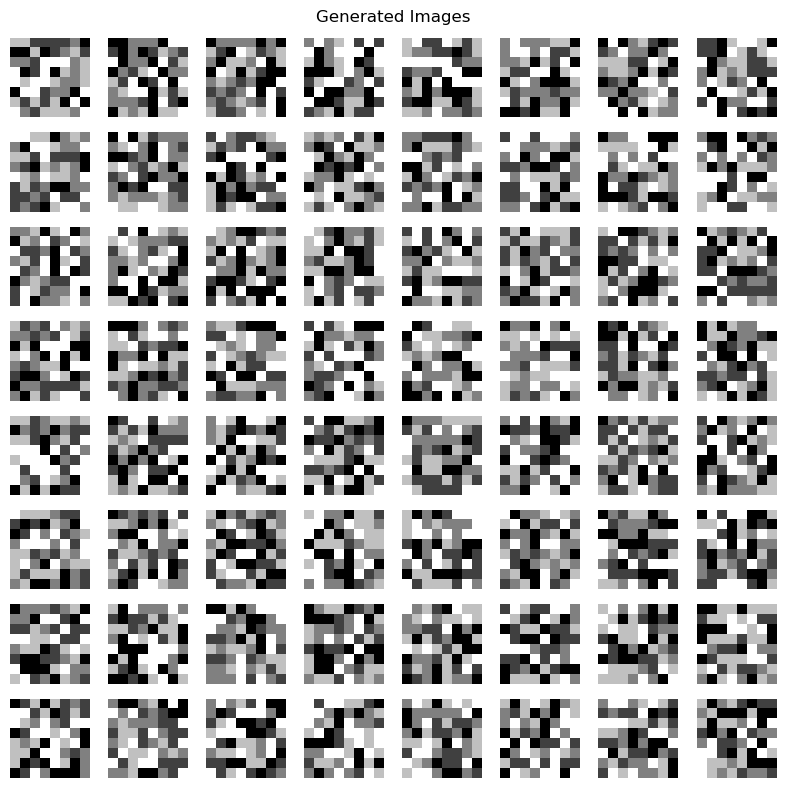

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)
generate_and_display_samples(new_model, num_steps=512, method="Gibbs", num_candidates=5)

## To summarize, the Langevin sampling method has a very good outcomes while the pictures generated by Gibbs Sampling is not good.

For this question, I referenced a few sites/ papers/ github repositories, especially:

- https://uvadlc-notebooks.readthedocs.io/

I spent 12 hours amount of time, I have some suggestions: Gibbus Sampling is too slow!